This notebook will try to answer a mixed bag of questions using recordings across three microphones (SMP1,7 and GRAS 1/4"), and angles. 

1. How stable is the playback of the speaker across time? [link](#q1)
    * These recordings have on-axis recordings with the GRAS mic. 
2. How much variation is there from one SMP mic to the other?
    * Comparison of sensitivity across different frequencies between SMP1 and 7. 

In [110]:
import dateutil

In [111]:
import datetime as dt
import dateutil
import glob
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import scipy.signal as signal 
import scipy.stats as stats
import soundfile as sf
from fullscale_calculations import *
from playback_code.playback_analysis import *

In [112]:
fs = 192000
dB = lambda X : 20*np.log10(abs(X))
dbrms = lambda X: dB(np.sqrt(np.mean(X**2.0)))
b,a = signal.butter(2,8000/fs*0.5,'high')
highpass = lambda X: signal.filtfilt(b,a,X)

In [113]:
print(f'Notebook cell run at : {dt.datetime.now()}')

Notebook cell run at : 2021-04-27 17:34:57.453131


In [114]:
%matplotlib notebook

<a id='q1'></a>
## How stable is the speaker playback across time?
The measurements were performed across about 1hour 15 mins. 

In [115]:
gras_files_onaxis = glob.glob('2021-04-22\\gras_gaindB_46_azimuth_angle_0_*')
gras_files_onaxis

['2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_14-57-04.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_14-58-24.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_14-58-54.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_14-59-17.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_14-59-39.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_15-00-02.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_16-06-49.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_16-07-16.wav',
 '2021-04-22\\gras_gaindB_46_azimuth_angle_0_2021-04-22_16-14-08.wav']

<IPython.core.display.Javascript object>


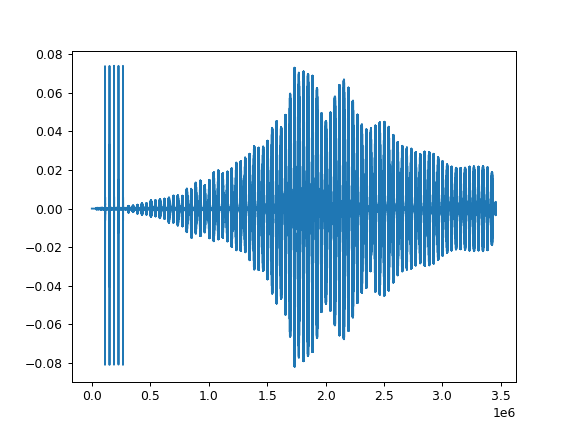

In [116]:
plt.figure()
plt.plot(sf.read(gras_files_onaxis[0])[0])

In [117]:
fs = 192000
half_durn = 9 # secs
half_durnsamples = int(half_durn*fs)
sweeps_section = int(1.5*fs)
audio_hp = []
tones_dbrms = []
audio_dbrms1half = []
audio_dbrms2half = []
sweeps_dbrms = []
silence_dbrms = []
tones_dbrms = []
for each in gras_files_onaxis:
    audio,fs = sf.read(each)
    highpassed = highpass(audio)
    audio_hp.append(highpassed)
    tones_dbrms.append(dbrms(highpassed[int(1.5*fs):]))
    audio_dbrms1half.append(dbrms(highpassed[int(1.5*fs):half_durnsamples]))
    audio_dbrms2half.append(dbrms(highpassed[half_durnsamples:]))
    sweeps_dbrms.append(dbrms(highpassed[int(0.5*fs):sweeps_section]))
    silence_dbrms.append(dbrms(highpassed[:int(0.5*fs)]))

In [118]:
datetimes_files = []
for each in gras_files_onaxis:
    timestamp = each[-23:-4]
    ymd, hhmmss = timestamp.split('_')
    fmted_ts = ymd + ' ' + hhmmss.replace('-',':')
    datetimes_files.append(dateutil.parser.parse(fmted_ts))

In [119]:
datetimes_files[0]

datetime.datetime(2021, 4, 22, 14, 57, 4)

In [120]:
time_since_start = [ (each-datetimes_files[0]).seconds/60.0 for each in datetimes_files] # minutes 

In [121]:
time_since_start[0] += 0.25 # just adding 1/4 a minute to help with visualisation -- THIS IS ACTUALLY 0 SECONDS WRT START!!

<IPython.core.display.Javascript object>


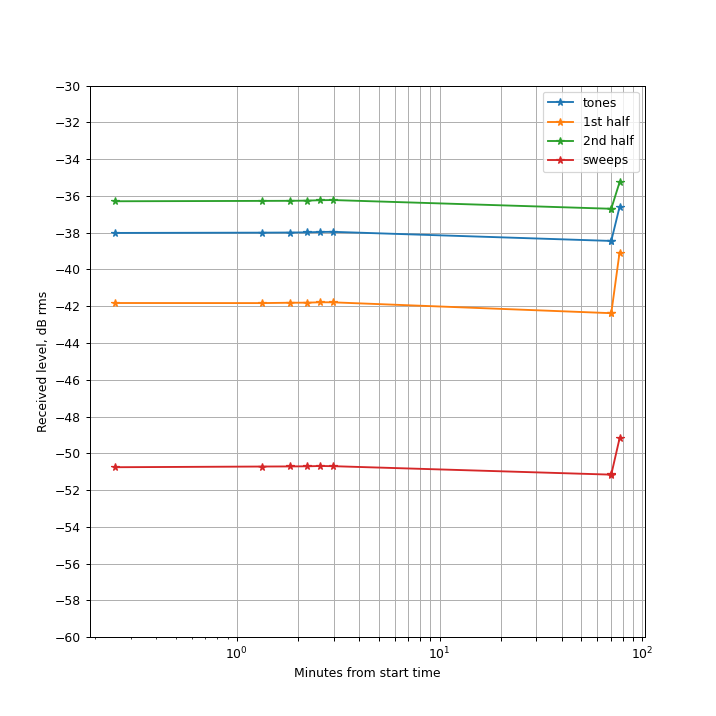

In [122]:
plt.figure(figsize=(8,8))
a0 = plt.subplot(111)
plt.plot(time_since_start, tones_dbrms,'-*',label='tones')
plt.plot(time_since_start, audio_dbrms1half,'-*',label='1st half')
plt.plot(time_since_start, audio_dbrms2half,'-*',label='2nd half')
plt.plot(time_since_start, sweeps_dbrms,'-*',label='sweeps')
#plt.xticks(range(len(wavfiles)),angles,rotation=60);
plt.legend()
plt.ylim(-60,-30);plt.yticks(np.arange(-60,-28,2));plt.grid()
plt.ylabel('Received level, dB rms');plt.xlabel('Minutes from start time');
a0.set_xscale('log');
plt.xticks(np.concatenate((np.arange(1,11), np.arange(20,110,10))));

In [123]:
diff_to_first = lambda X : X-X[0]

<IPython.core.display.Javascript object>


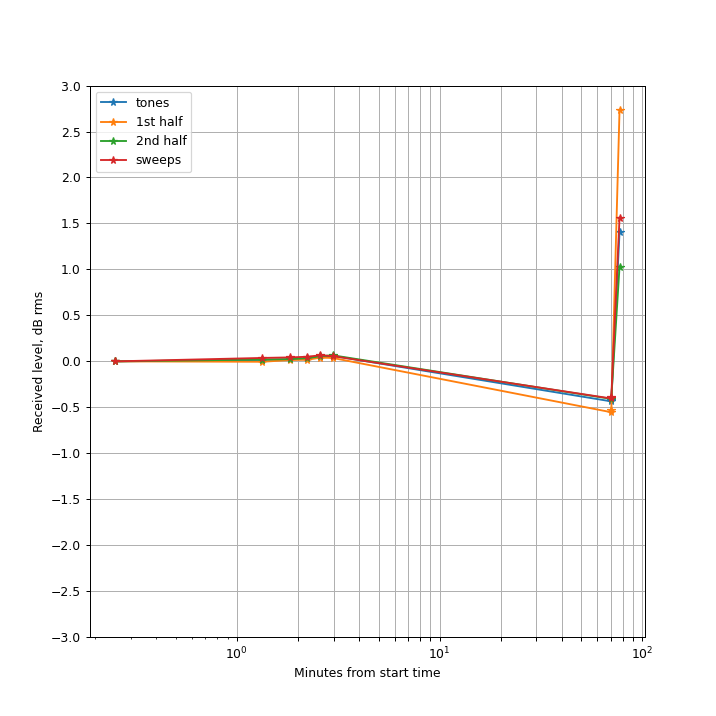

In [124]:
plt.figure(figsize=(8,8))
a0 = plt.subplot(111)
plt.plot(time_since_start, diff_to_first(tones_dbrms),'-*',label='tones')
plt.plot(time_since_start, diff_to_first(audio_dbrms1half),'-*',label='1st half')
plt.plot(time_since_start, diff_to_first(audio_dbrms2half),'-*',label='2nd half')
plt.plot(time_since_start, diff_to_first(sweeps_dbrms),'-*',label='sweeps')
#plt.xticks(range(len(wavfiles)),angles,rotation=60);
plt.legend()
plt.ylim(-3,3);plt.yticks(np.arange(-3,3.5,0.5));plt.grid()
plt.ylabel('Received level, dB rms');plt.xlabel('Minutes from start time');
a0.set_xscale('log');
plt.xticks(np.concatenate((np.arange(1,11), np.arange(20,110,10))));

### There is a weird jump of at least 1.5-2.5 dB in source level. The largest jump can be localised to the 1st half of the recording. Let's take a look using a power spectrum. 

 ### NEED TO TAKE A MORE DEEPER LOOK TO SEE WHERE THE OVERALL DIFFERENCE IS COMING FROM - THE SWEEPS OR THE TONES!!

In [125]:
first_audio, _ = sf.read(gras_files_onaxis[0], start=int(1.5*fs))
last_audio, _ = sf.read(gras_files_onaxis[-1], start=int(1.5*fs))
firstlast = [first_audio, last_audio]
power_spectra = [dB(np.fft.rfft(each)) for each in firstlast]
freqs = np.fft.rfftfreq(firstlast[0].size, 1/fs)

In [126]:
# threshold out the noise to see the difference better
threshold = 3
def threshold_spectra(X, threshold, thresh_val=0):
    leq_threshold = X<=threshold
    thresh_X = X.copy()
    thresh_X[leq_threshold] = thresh_val
    return thresh_X
power_spectra_cleaned = [ threshold_spectra(each, 5) for each in power_spectra]

<IPython.core.display.Javascript object>


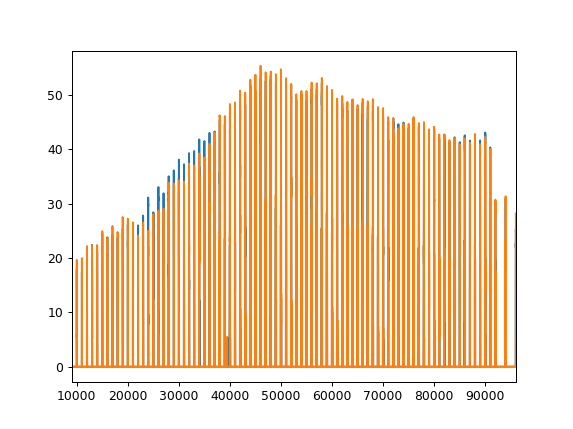

(9000.0, 96000.0)

In [127]:
plt.figure()
plt.plot(freqs,power_spectra_cleaned[0])
plt.plot(freqs,power_spectra_cleaned[1])
plt.xlim(9000, fs*0.5)

In [128]:
smooth_powerspectra = [np.convolve(each,np.ones(20)/20,'same') for each in power_spectra_cleaned]
diffspectra = power_spectra_cleaned[1]-power_spectra_cleaned[0]


In [129]:
smooth_diffspectra = signal.medfilt(diffspectra, 251)

<IPython.core.display.Javascript object>


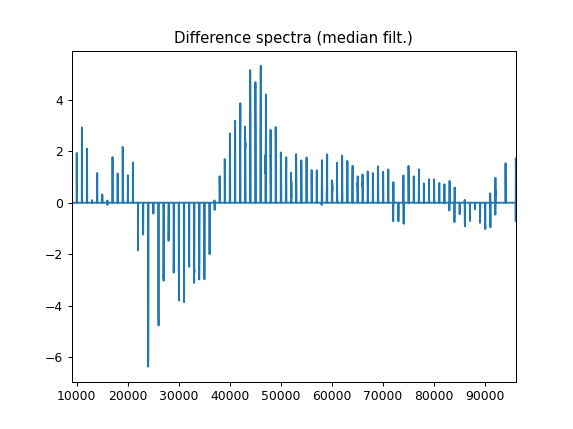

In [130]:
plt.figure()
plt.plot(freqs,smooth_diffspectra)
plt.xlim(9000, fs*0.5);plt.title('Difference spectra (median filt.)');

### There may be some kind of frequency dependent up and down shift across time. 

This observation begs the question:
* Would changing the speaker have an effect?
* Would reducing the playback/experiment duration have an effect?

### Speaker playback levels across frequency

We know the GRAS 1/4" mic has a sensitivity of -49.7 Vrms/Pa ($\pm$0.72 dB between 250Hz-100kHz), and the Fireface 802 front instrument port has a full-scale of 27dBu. The mic was ona 46 dB gain. 

Let's calculate the received level of each frequency. 

In [131]:
# split the whole recording into 90 parts
audio, fs = sf.read(gras_files_onaxis[0])
audio_bp = signal.filtfilt(b,a,audio)
rec_parts = np.array_split(audio_bp, 90)    

<IPython.core.display.Javascript object>


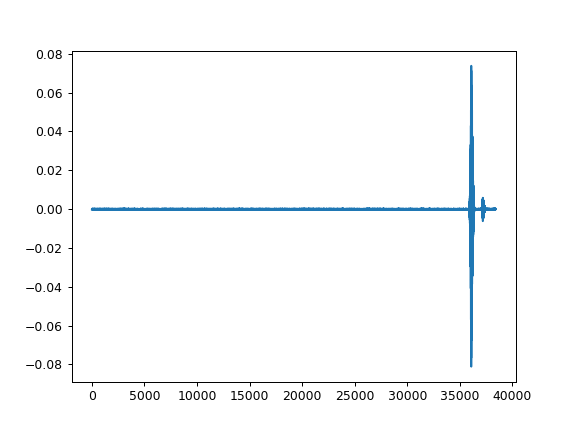

In [132]:
plt.figure()
plt.plot(rec_parts[2])

In [133]:
# get the p2p for each part:
waveform_pp = [ wave_p2p(each) for each in rec_parts]
waveform_dbpp = dB( np.array(waveform_pp)/2.0) # re 2
waveform_dbpp += -46 # remove gain to get actual pp
# FS of Fireface 802 in dB Vpp re 1V
fs_vpp = dbu2vp2p(27)
fs_dbV = dB(fs_vpp)
playback_levels_dbV = fs_dbV + waveform_dbpp# #  dBVpp re 1
playback_levels_dbV 

array([-83.69440861, -80.36401727, -34.39798972, -34.38987391,
       -34.39102615, -34.39735761, -34.38887611, -77.39206299,
       -67.19877365, -67.3778201 , -64.84834751, -62.62429094,
       -62.80976116, -59.68372648, -59.76098067, -58.23260451,
       -57.86075224, -55.83530259, -55.2683034 , -54.25879823,
       -54.18169491, -51.11704012, -50.0600222 , -49.78375431,
       -48.99714187, -50.38776419, -48.55347036, -47.13833748,
       -47.11111613, -47.70650023, -46.98560308, -46.00054807,
       -45.05421613, -44.83880945, -44.33829942, -43.35341578,
       -42.10056965, -42.14234825, -42.01192967, -41.06312182,
       -39.51963841, -38.6767106 , -39.21579919, -37.88245728,
       -36.18925734, -34.39501574, -34.79703701, -34.66249975,
       -34.89846907, -35.07146958, -35.94775398, -37.92602751,
       -38.65548884, -37.94409504, -36.71057881, -35.92722988,
       -35.6137147 , -36.17772333, -37.17345166, -38.39614114,
       -39.38161766, -39.88680382, -40.7511243 , -39.48

In [134]:
sensitivity_dBvrms = -49.17 # dBVrms/Pa
sensitivity_vrms = 10**(sensitivity_dBvrms/20.0)
sensitivity_vpp = vrms2vp2p(sensitivity_vrms)
sensitivity_vpp


0.009841130559241589

In [135]:
playback_levels_V = 10**(playback_levels_dbV/20.0) # Pa
playback_levels_pa = playback_levels_V*(1/sensitivity_vpp)
ref_level = 20*10**-6
playback_levels_dbspl = dB(playback_levels_pa/ref_level)
playback_levels_dbspl

array([50.4240916 , 53.75448294, 99.7205105 , 99.72862631, 99.72747406,
       99.7211426 , 99.72962411, 56.72643723, 66.91972656, 66.74068011,
       69.27015271, 71.49420927, 71.30873906, 74.43477374, 74.35751955,
       75.88589571, 76.25774797, 78.28319763, 78.85019682, 79.85970199,
       79.93680531, 83.0014601 , 84.05847801, 84.33474591, 85.12135835,
       83.73073602, 85.56502986, 86.98016273, 87.00738409, 86.41199999,
       87.13289713, 88.11795215, 89.06428408, 89.27969076, 89.7802008 ,
       90.76508443, 92.01793056, 91.97615197, 92.10657055, 93.0553784 ,
       94.59886181, 95.44178962, 94.90270103, 96.23604294, 97.92924287,
       99.72348448, 99.32146321, 99.45600047, 99.22003115, 99.04703064,
       98.17074624, 96.19247271, 95.46301138, 96.17440518, 97.40792141,
       98.19127034, 98.50478552, 97.94077689, 96.94504856, 95.72235907,
       94.73688256, 94.2316964 , 93.36737592, 94.63755458, 94.95676097,
       95.03562277, 94.50482225, 93.60782899, 92.7160499 , 92.19

<IPython.core.display.Javascript object>


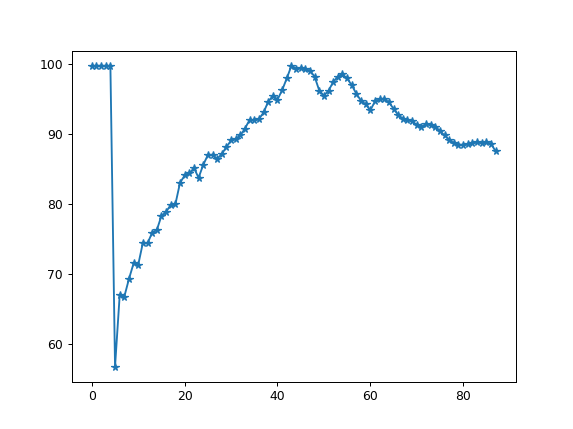

In [136]:
plt.figure()
plt.plot(playback_levels_dbspl[2:],'-*')

## SMP mic levels

In [137]:
smp1_recs = glob.glob('2021-04-22/SMP1_*')
smp7_recs = glob.glob('2021-04-22/SMP7_*')
smp1_recs

['2021-04-22\\SMP1_gaindB_30_azimuth_angle_0_2021-04-22_15-12-32.wav',
 '2021-04-22\\SMP1_gaindB_30_azimuth_angle_0_2021-04-22_15-12-59.wav',
 '2021-04-22\\SMP1_gaindB_30_azimuth_angle_0_2021-04-22_15-24-32.wav',
 '2021-04-22\\SMP1_gaindB_30_azimuth_angle_15_2021-04-22_15-25-04.wav',
 '2021-04-22\\SMP1_gaindB_30_azimuth_angle_30_2021-04-22_15-16-12.wav',
 '2021-04-22\\SMP1_gaindB_30_azimuth_angle_30_2021-04-22_15-16-34.wav',
 '2021-04-22\\SMP1_gaindB_30_azimuth_angle_30_2021-04-22_15-25-33.wav',
 '2021-04-22\\SMP1_gaindB_30_azimuth_angle_45_2021-04-22_15-26-03.wav',
 '2021-04-22\\SMP1_gaindB_30_azimuth_angle_60_2021-04-22_15-17-05.wav',
 '2021-04-22\\SMP1_gaindB_30_azimuth_angle_60_2021-04-22_15-17-28.wav',
 '2021-04-22\\SMP1_gaindB_30_azimuth_angle_60_2021-04-22_15-26-58.wav',
 '2021-04-22\\SMP1_gaindB_30_azimuth_angle_75_2021-04-22_15-27-35.wav',
 '2021-04-22\\SMP1_gaindB_30_azimuth_angle_90_2021-04-22_15-18-06.wav',
 '2021-04-22\\SMP1_gaindB_30_azimuth_angle_90_2021-04-22_15-18-29.w

In [138]:
smp7_recs

['2021-04-22\\SMP7_gaindB_30_azimuth_angle_0_2021-04-22_15-40-26.wav',
 '2021-04-22\\SMP7_gaindB_30_azimuth_angle_0_2021-04-22_15-40-51.wav',
 '2021-04-22\\SMP7_gaindB_30_azimuth_angle_15_2021-04-22_15-41-30.wav',
 '2021-04-22\\SMP7_gaindB_30_azimuth_angle_30_2021-04-22_15-42-33.wav',
 '2021-04-22\\SMP7_gaindB_30_azimuth_angle_45_2021-04-22_15-43-14.wav',
 '2021-04-22\\SMP7_gaindB_30_azimuth_angle_60_2021-04-22_15-44-12.wav',
 '2021-04-22\\SMP7_gaindB_30_azimuth_angle_75_2021-04-22_15-44-45.wav',
 '2021-04-22\\SMP7_gaindB_30_azimuth_angle_90_2021-04-22_15-45-19.wav',
 '2021-04-22\\SMP7_gaindB_30_elevation_angle_0_2021-04-22_15-57-19.wav',
 '2021-04-22\\SMP7_gaindB_30_elevation_angle_15_2021-04-22_15-57-56.wav',
 '2021-04-22\\SMP7_gaindB_30_elevation_angle_30_2021-04-22_15-58-32.wav',
 '2021-04-22\\SMP7_gaindB_30_elevation_angle_45_2021-04-22_15-59-06.wav',
 '2021-04-22\\SMP7_gaindB_30_elevation_angle_45_2021-04-22_16-02-00.wav',
 '2021-04-22\\SMP7_gaindB_30_elevation_angle_60_2021-04-2

In [139]:
pbk_freqs = np.arange(10,91,1)*10**3

In [199]:
audio, fs = sf.read(smp7_recs[5])
audio_bp = signal.filtfilt(b,a,audio)
rec_parts = np.array_split(audio_bp, 90)    

waveform_pp = [ wave_p2p(each) for each in rec_parts]
waveform_dbpp = dB( np.array(waveform_pp)/2.0) # re 2
waveform_dbpp += -30 # remove gain to get actual pp

<IPython.core.display.Javascript object>


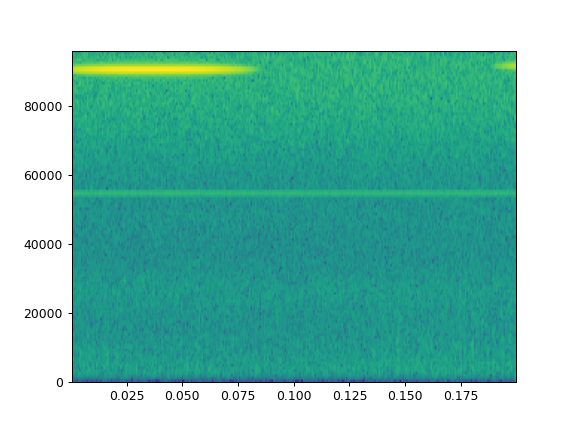

In [200]:
plt.figure()
plt.specgram(rec_parts[-1], Fs=fs);

In [201]:
playback_levels_dbV = fs_dbV + waveform_dbpp# #  dBVpp re 1
playback_levels_Vpp = 10**(playback_levels_dbV/20.0)
playback_levels_Vrms = vpp2rms(playback_levels_Vpp)
#playback_levels_dbV

In [202]:
dbV_pa_smp = dB(playback_levels_Vrms/playback_levels_pa)

The ultrasonic sensitivity data is from the datasheet online [here](https://www.knowles.com/docs/default-source/model-downloads/spu0410lr5h-qb-revh32421a731dff6ddbb37cff0000940c19.pdf?Status=Master&sfvrsn=cebd77b1_4). Data digitised from the graph using the [WebPlotDigitizer](https://apps.automeris.io/wpd/) tool.

In [203]:
online_response = pd.read_csv('knowles_spu0410LR5H.csv') # dB relative to sensitivity at 1 kHz

<IPython.core.display.Javascript object>


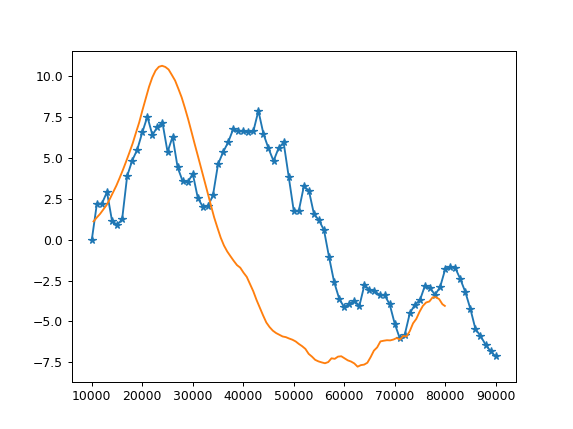

In [204]:
plt.figure()
plt.plot(pbk_freqs,dbV_pa_smp[-81:]-dbV_pa_smp[-81:][0],'-*') # align it manually for now
plt.plot(online_response['frequency'], online_response['rel_db'])
#plt.ylim(-50,-20)